In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector

In [5]:
# Merge our DFT result data with the Kraken ML data for the ligands.
dft_df = pd.read_csv("dft_data/lambda_max_v_bond_len_H_only_trialkylphosphine_like.csv")
kraken_df = pd.read_csv("kraken_data/ml_8_210.csv")

merged_df = pd.merge(dft_df, kraken_df, on="molecule_id")
merged_df.head()
# Effectively, I think of this as a left joining kraken_df on dft_df

molecule_id  lambda_max  shift  Pd-H_length  \
0            8       395.4    0.0      2.30055   
1           12       421.5   26.1      2.59931   
2        16511       369.7  -25.7      2.05612   
3        16670       383.6  -11.8      2.09212   
4        16848       391.8   -3.6      2.11877   

                                      smiles  dipolemoment_max  pyr_P_max  \
0                CC(C)(C)P(C(C)(C)C)C(C)(C)C          0.785410   0.814829   
1               CC(C)(C)CP(C(C)(C)C)C(C)(C)C          0.819760   0.883014   
2          CCC#CC(C)(C)P(CC(C)(C)C)CC(C)(C)C          0.828542   0.937721   
3           CC(C)(C)CP(CC(C)(C)C)[Si](C)(C)C          1.296638   0.944198   
4  CC(C)(C)CP(CC(C)(C)C)C12CC3CC(CC(C3)C1)C2          1.203256   0.926695   

   pyr_alpha_max  qpole_amp_max  qpoletens_xx_max  ...  \
0      32.633045       2.286466          1.155208  ...   
1      28.707630       1.997507          0.856250  ...   
2      21.047157       4.292618          3.905047  ...   
3      21.833437       2.785987          1.637620  ...   
4      24.450110       2.891620          1.373714  ...   

   vbur_qvbur_max_boltzmann_average  vbur_qvbur_min_boltzmann_average  \
0                         20.849024                         14.705131   
1                         21.402498                         14.062596   
2                         19.559307                         15.134177   
3                         20.133944                         13.691624   
4                         21.962236                         13.999315   

   vbur_qvtot_max_boltzmann_average  vbur_qvtot_min_boltzmann_average  \
0                         92.370575                         50.689070   
1                         89.652150                         54.039700   
2                         95.923110                         64.802795   
3                         98.138070                         58.803800   
4                        124.913170                         60.777004   

   vbur_ratio_vbur_vtot_boltzmann_average  vbur_vbur_boltzmann_average  \
0                                0.277816                    72.062120   
1                                0.271465                    74.782196   
2                                0.236930                    76.982850   
3                                0.241775                    72.455710   
4                                0.210782                    77.970245   

   vbur_vtot_boltzmann_average  vmin_r_boltzmann_average  \
0                    253.71219                  1.756687   
1                    271.61676                  1.767097   
2                    338.08795                  1.775052   
3                    308.80276                  1.823043   
4                    359.02414                  1.771015   

   vmin_vmin_boltzmann_average  volume_boltzmann_average  
0                    -0.069888                 320.95413  
1                    -0.064135                 345.01490  
2                    -0.056829                 424.17822  
3                    -0.053327                 390.21000  
4                    -0.059455                 455.53787  

[5 rows x 195 columns]

In [6]:
# Let's start with the top 20 features in the first principal component from our PCA (see ligand_pca.ipynb)
# Then let's examine their multicollinearity and remove features until we have significantly reduced that.
# We can also use various algorithms to do feature selection for us at this point.

# Since these data are all related to complexes with some agostic interaction, I have decided to include the distance between
# Pd and H (Pd-H_length) to see if the model hones in on this feature and whether that is generally helpful to us.

first_pca_20_and_Pd_H_length = [
    "Pd-H_length",
    "nbo_lp_P_percent_s_boltzmann_average",
    "nbo_lp_P_occ_boltzmann_average",
    "nmrtens_sxx_P_boltzmann_average",
    "vmin_r_boltzmann_average",
    "nmr_P_boltzmann_average",
    "vbur_max_delta_qvtot_max",
    "vbur_max_delta_qvtot_vburminconf",
    "vbur_ratio_vbur_vtot_boltzmann_average",
    "vbur_max_delta_qvtot_boltzmann_average",
    "vbur_max_delta_qvtot_min",
    "sterimol_burB5_boltzmann_average",
    "vbur_ovbur_max_max",
    "vbur_qvbur_max_max",
    "vbur_ovbur_max_vburminconf",
    "vbur_ovbur_max_boltzmann_average",
    "vbur_qvbur_max_boltzmann_average",
    "vbur_ovbur_max_min",
    "vbur_qvbur_max_min",
    "vbur_far_vtot_max"
]
features = merged_df[first_pca_20_and_Pd_H_length]

# plt.figure(figsize= (20, 20))
# corr_heatmap = sns.heatmap(features.corr(), annot=True)

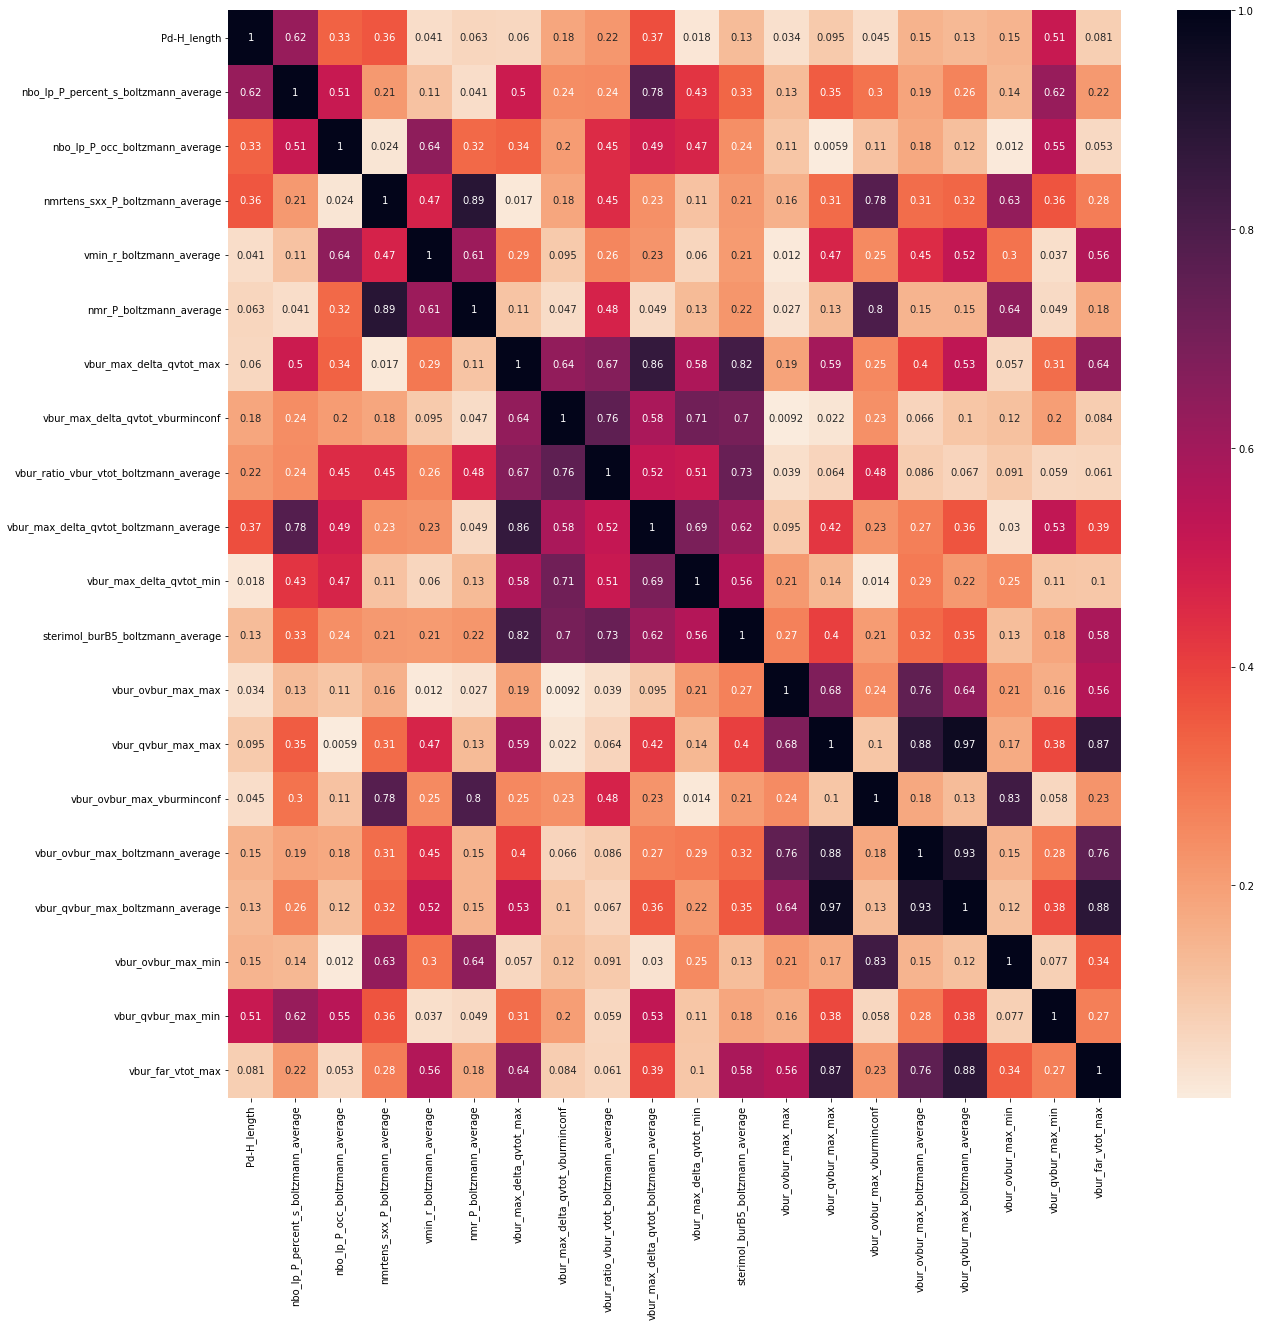

In [7]:
# Let's do an absolute heatmap (and set the color axis so that 0 is light, 1 is dark):
plt.figure(figsize= (20, 20))
cmap = sns.cm.rocket_r
abs_corr_heatmap = sns.heatmap(abs(features.corr()), annot=True, cmap=cmap)

In [8]:
# Set the feature and target values:
X = features.values
target = merged_df.columns[1]
y = merged_df[target].values

In [9]:
print(sklearn.metrics.get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'd2_absolute_error_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'neg_root_mean_squared_log_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'r

In [10]:
# I think the "best" model for us is probably the Elastic Net, so let's stick with that.

# We really need to do some hyperparameter tuning when it comes to alpha and l1_ratio. 
# Let's do a Grid Search CV
# Seems like I'd have to use Cp or some information criterion as the scoring metric?
# Those don't seem to be available. TODO: address scoring metric choice

elastic_net_gs = ElasticNet(tol=0.0001, max_iter=1000000)

search_space = {
    "alpha": [0.0000001, 0.000001, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10],
    "l1_ratio": [0.1, 0.2, 0.3, 0.4, 0.45, 0.49, 0.5, 0.51, 0.55, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99, 1]
}

gs_elastic_net = GridSearchCV(
    estimator=elastic_net_gs,
    param_grid=search_space,
    scoring=["r2"],
    refit="r2",
    cv=5
)

In [11]:
gs_elastic_net.fit(X, y)

C:\Users\pmwad\anaconda3\envs\rdkit-env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.276e-01, tolerance: 2.172e-01
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=ElasticNet(max_iter=1000000),
             param_grid={'alpha': [1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005,
                                   0.001, 0.01, 0.1, 1, 10],
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.45, 0.49, 0.5, 0.51,
                                      0.55, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95,
                                      0.99, 1]},
             refit='r2', scoring=['r2'])

In [12]:
print(f"Grid Search Elastic Net model training score: {gs_elastic_net.score(X, y)}")

Grid Search Elastic Net model training score: 0.9999998488801118


In [13]:
best = gs_elastic_net.best_estimator_
best.get_params()

{'alpha': 1e-05,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.1,
 'max_iter': 1000000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

<Axes: >

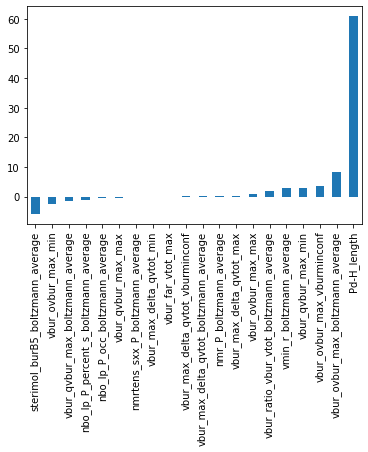

In [14]:
pd.Series(best.coef_, first_pca_20_and_Pd_H_length).sort_values(ascending = True).plot(kind = "bar")

In [ ]:
# So we are basically just selecting Pd-H length in this model. 